In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from preprocess_functions import preprocess #preprocess is a class containing all the function

## Set up paths and params, then load data and fill object

In [2]:
path = '/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2721/2024_12_05-15_19_37'
save_to_path = path #path to which you want the data to ba saved. Can be the same as the rootdir
# selecting a sensor. For now, the functions respond to 'G8m', 'g5-HT3', 'rG1' or asks for user input for half decay time in ms.
sensors = {'470':'g5-HT3', '560':'rG1', '410':'g5-HT3'}
target_area = ('X')

In [3]:
#Create an object which will contain an increasing amount of information as functions are called on
processed = preprocess(path, sensors)
# extract all relevant and irrelevant info from the Fluorescence.csv file which contains the metadata 
processed.Info = processed.get_info()

In [4]:
#processed.create_basic() uses folder structure to get animalID, experiment time and experiment type
#CHECK all split functions in the function, as they may be different depending on the folder structure 
#`mousename = self.path.split('/')[-3]#[:6]`
print (processed.path.split('/'))
print ("recording time:", processed.path.split('/')[-2][:]) # recording time
print ("animal ID:", processed.path.split('/')[-3])#[:6]) #animal ID
print ("experiments:", processed.path.split('/')[-4][:]) #experiments
print ("session (seems unused):", processed.path.split('/')[-3][5:]) # session
#WE HAVE a problem here with session BUT I don't think it is used anyway 

['', 'Users', 'rancze', 'Documents', 'Data', 'vestVR', 'Cohort1', 'photometry', 'Cohort1_visual_mismatch_day1', 'B6J2721', '2024_12_05-15_19_37', '']
recording time: 2024_12_05-15_19_37
animal ID: B6J2721
experiments: Cohort1_visual_mismatch_day1
session (seems unused): 21


In [5]:
#Loads Events.csv and Fluorescence-unaligned.csv
#Aligns to 470 nm timestamps (assumes 470 exists) and cuts data if needed (almost never)
#Returns processed dataframes below

(
    processed.rawdata, 
    processed.data, 
    processed.data_seconds, 
    processed.signals, 
    processed.save_path
) = processed.create_basic(
    path_save = save_to_path, 
    cutstart = False,
    cutend = False,
    target_area = target_area
)


Preprocessing data for B6J2721 at 2024_12_05-15_19_37...

Final save path: 
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2721/2024_12_05-15_19_37/photometry_processed/B6J2721


In [6]:
#Not sure why is even needed
#processed.events = processed.extract_events()
'''
now we have an element 'events' containing timestamped events
for each event there will be a _starts and a _stops and a _event
 _starts: numpy nans for all rows except at the time stamp where the event starts
 _stops: numpy nans for all rows except at the time stamp where the event stops
 _events: False whenever the event did not take place, and True while it did take place
 The event is named the same as was as it was recorded
'''
#processed.events
None

### Filtering
All the sigals are low pass filtered using a butterworth filter.  
method = "auto" cutoff frequncy ~sample_rate/2 Hz  
method = "sensor" cutoff frequency is determined in the function using the sensors dictionary  
savefig = False by default, True will save the figure 

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz


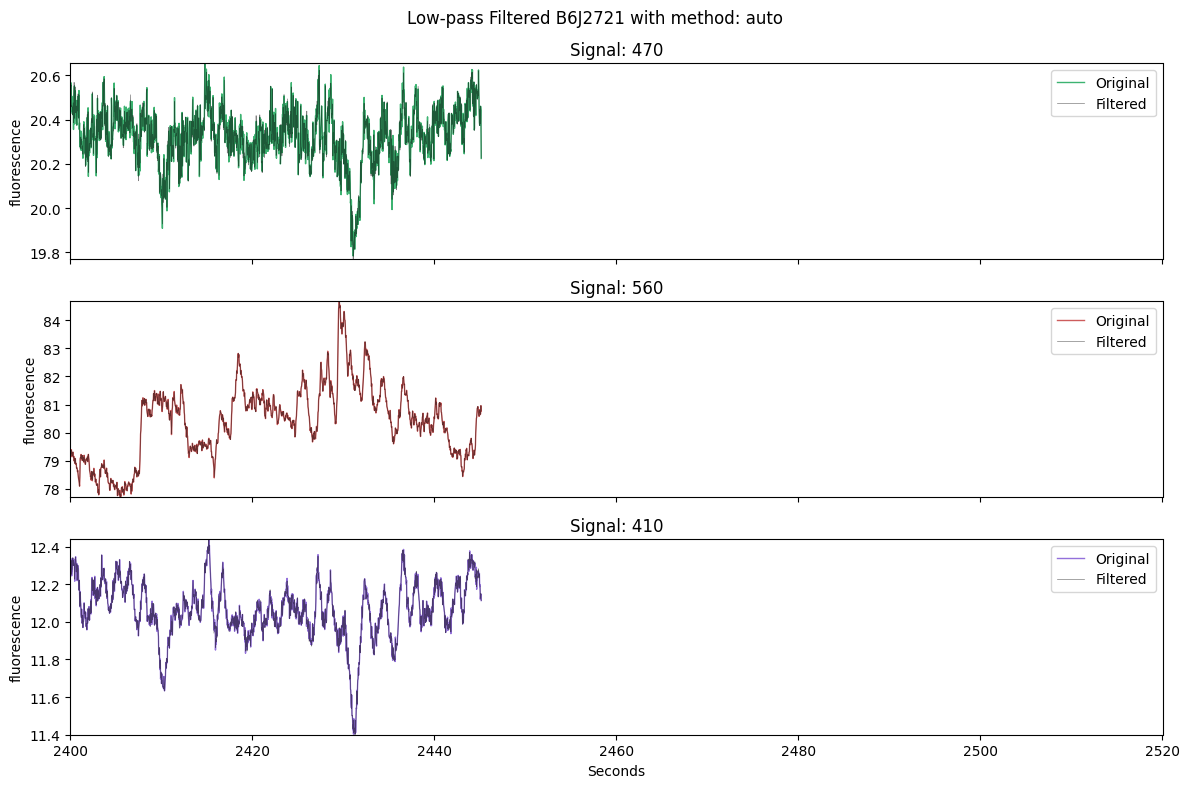

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz


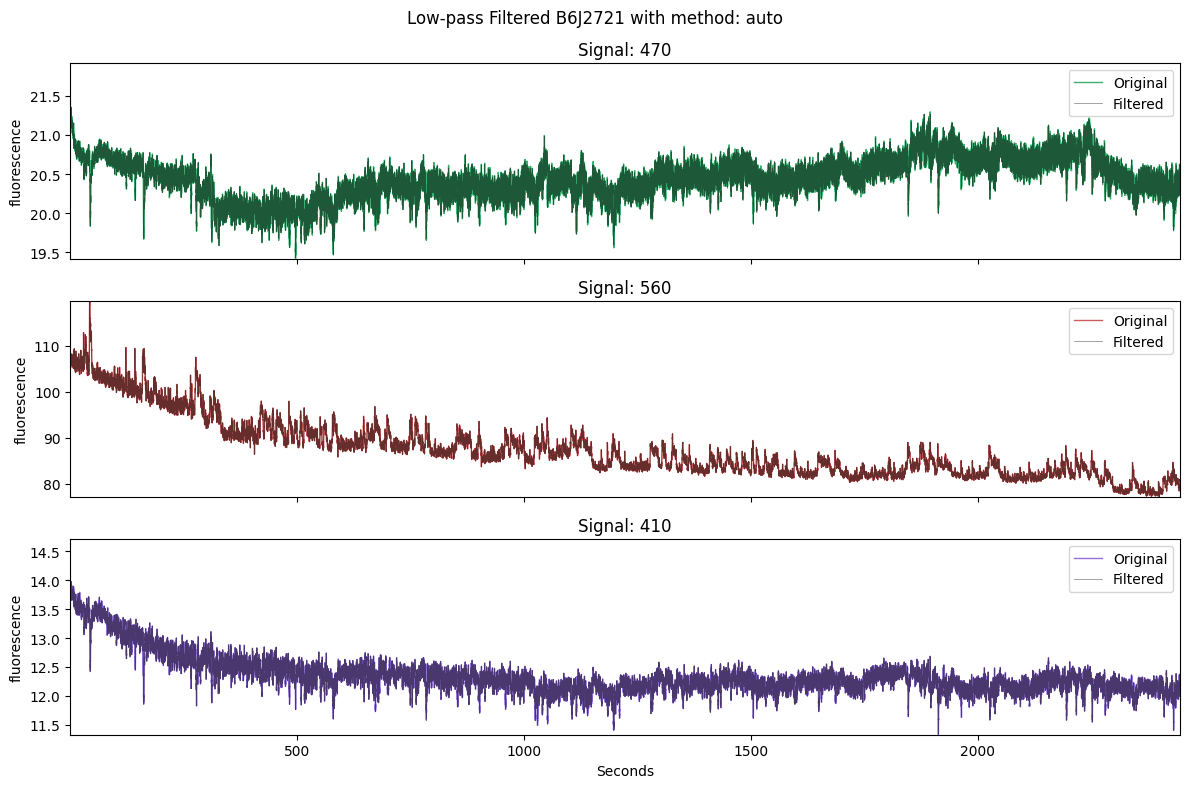

In [7]:
processed.filtered = processed.low_pass_filt(method = "auto", plot=True, x_start=2400, x_end=2520)
processed.filtered = processed.low_pass_filt(method = "auto", plot=True)

### Detrending
A double exponential fit is made to account for sources of bleaching and the signal is corrected.  
method = "subtractive" assumes bleaching is sensor-independent (e.g. autofluorescence)  
method = "divisive" assumes bleaching comes from the sensor. This is most plausible.  
savefig = False by default, True will save the figure  
**N.B.** divisive detrended data is already dF/F. 

Parameters used for detrending filtered_470:  [2.04169144e+01 5.83841231e-01 5.47235291e-01 7.64812565e+01
 4.06901543e-02]
Parameters used for detrending filtered_560:  [3.07560200e-06 1.75936855e+01 9.09654848e+01 1.96569487e+04
 1.34476421e-02]
Parameters used for detrending filtered_410:  [ 12.18087151   0.55344918   1.00790765 312.5415074    0.37792082]


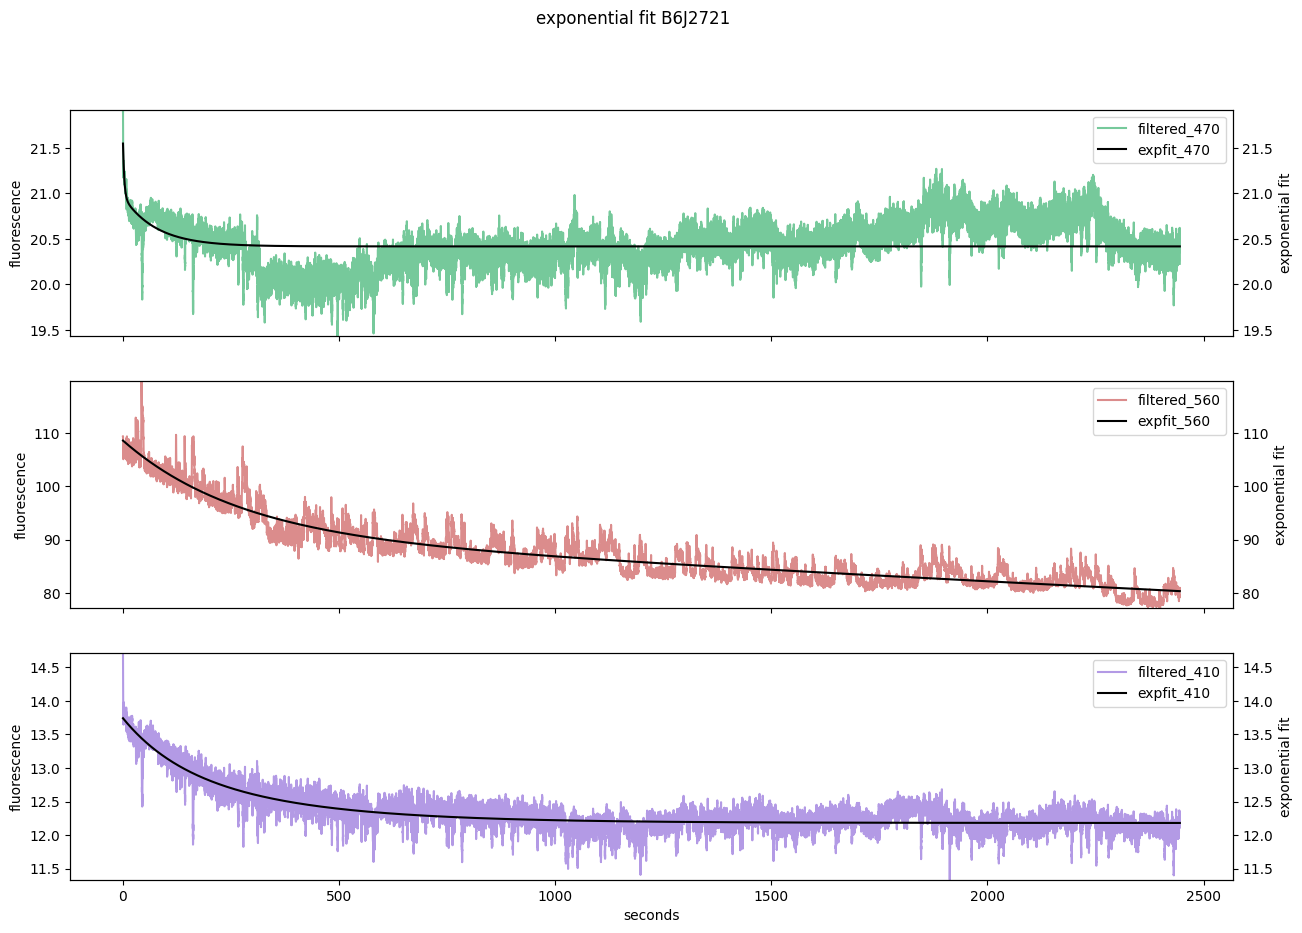

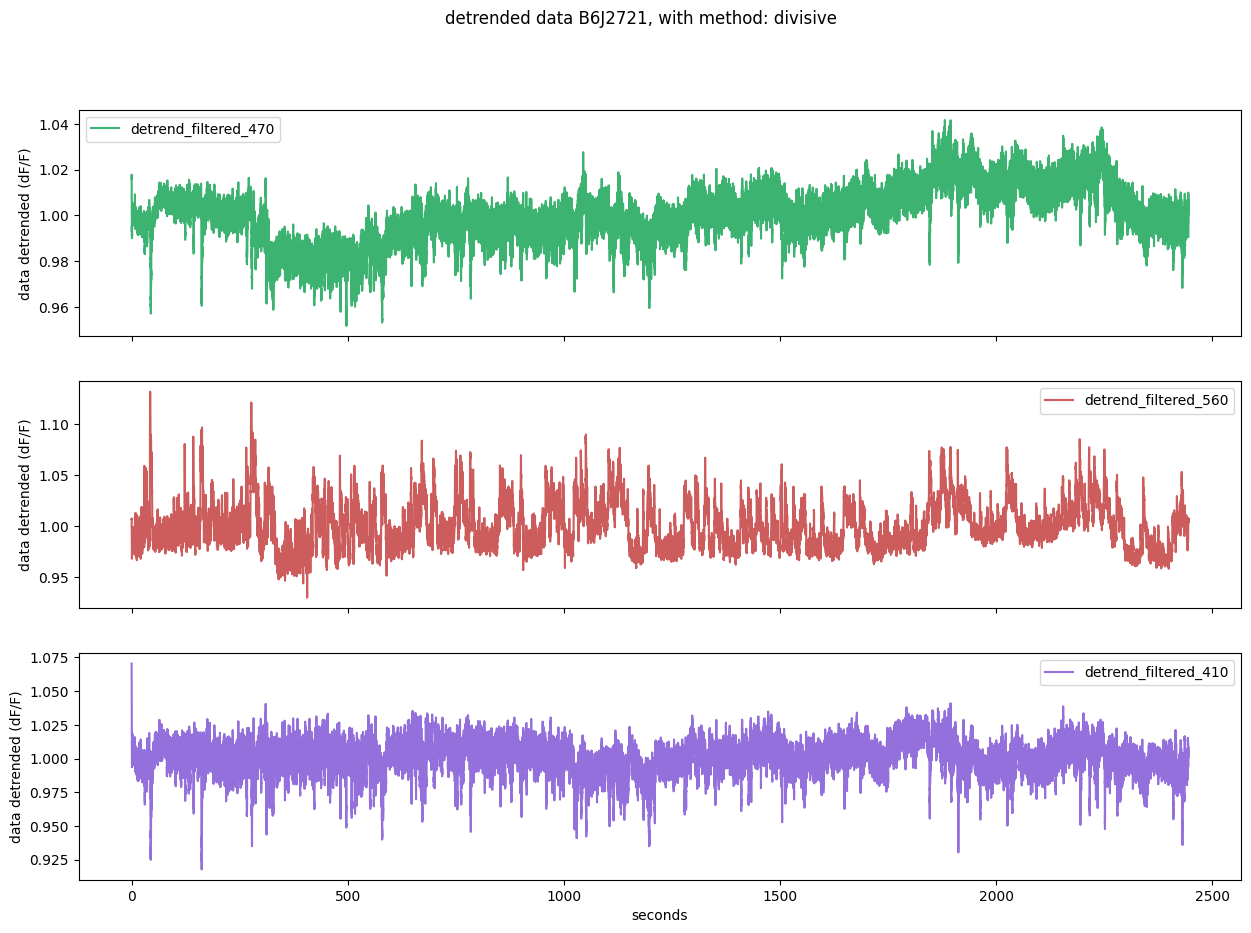

In [8]:
processed.data_detrended, processed.exp_fits = processed.detrend(plot = True, method = "divisive")

### Motion correction
There is a motion correction function that can be used. It is now set to use the 560 nm signal, because of my doubts with the relevans of the 410 nm signal as isosbestic trace. For now, I recommend not running this one.
Check function before use, not checked in Jan 2025. 

`processed.motion_corr = processed.movement_correct(plot = True)`

### Z-scoring
Standard Z-scoring of the signal.  
If divisive detrending was used, this is the z-scored dF/F.  
If subtractive detrending was used, this is the z-scored signal.  
motion = False does not use motion corrected signal  
savefig = False by default, True will save the figure

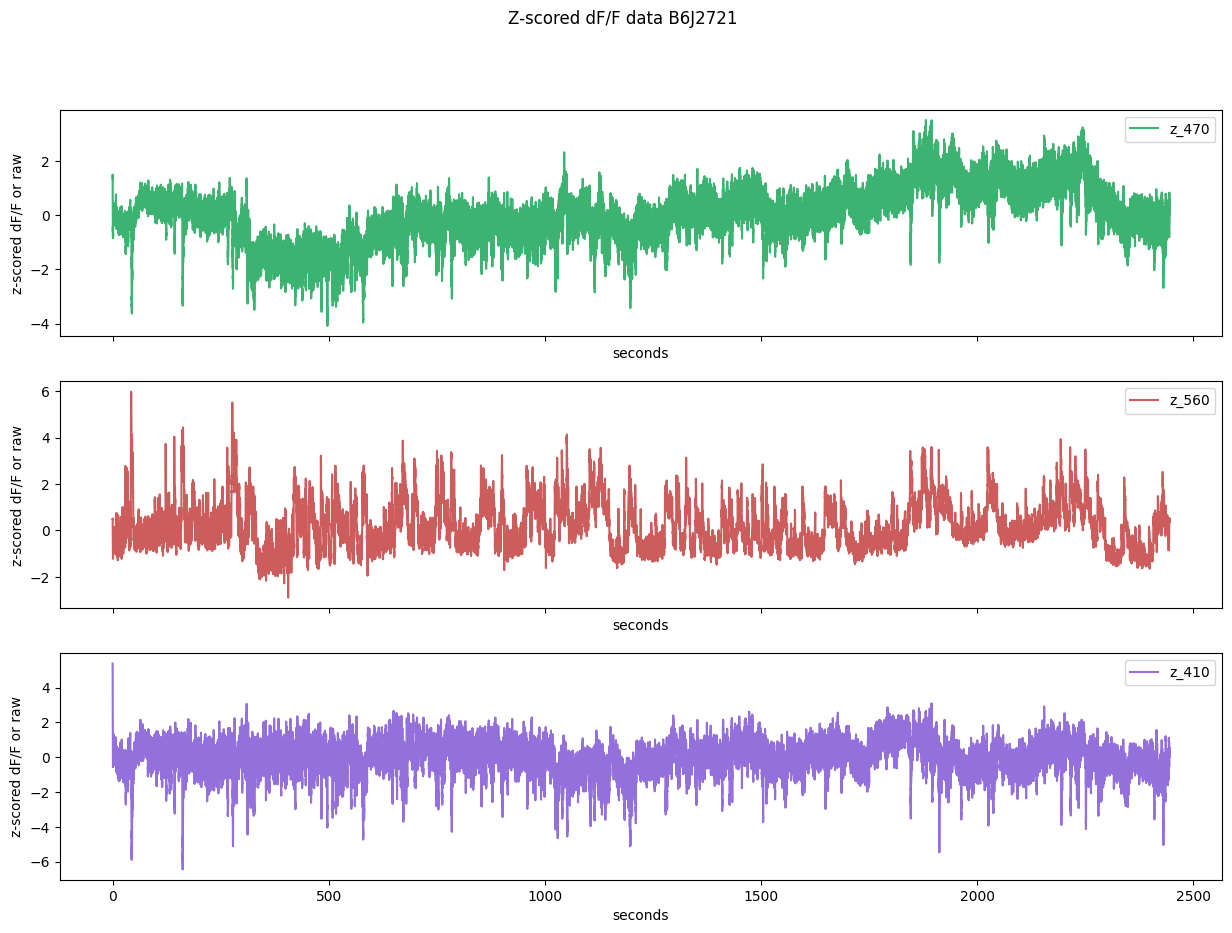

In [9]:
processed.zscored = processed.z_score(motion = False, plot = True)

### Delta F / F

WITH divisive detrending, this is not needed

This is a standard way of calculating the detla F over F signal, i.e. the % change in signal. I do think it is a bit weird to use the detrending exponential fit again. I have wondered if I should change it to just a linear fit to the current detrended signal. For now I do this based on the fiber photometry primer paper code: https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb

Again, 'motion' can be set to True, bu tis defaulth False
savefig = False by default, True will save the figure 

The method used for detrending was divisive, deltaF/F has been already calculated


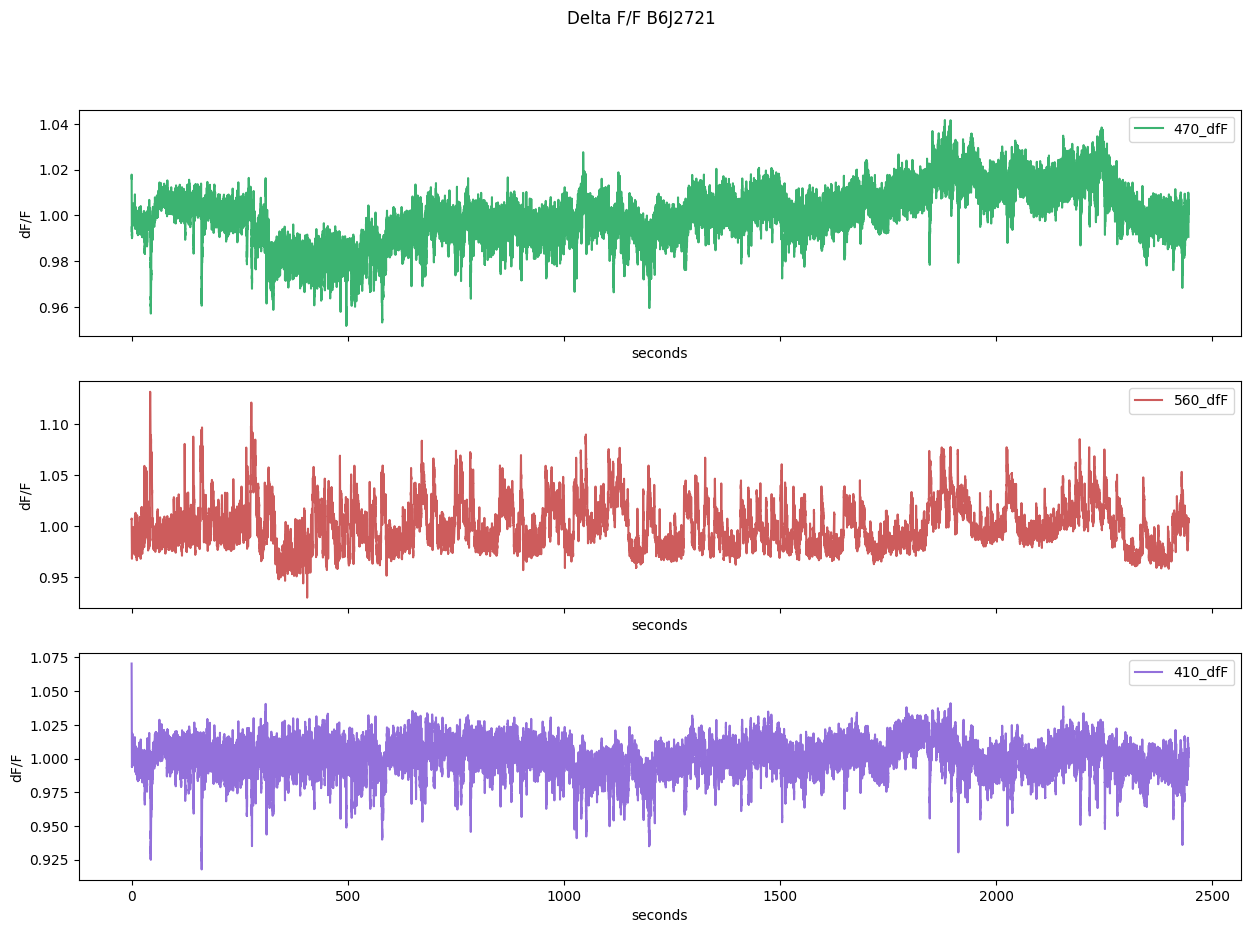

In [10]:
processed.deltaF_F = processed.get_deltaF_F(motion = False, plot = True)

### Add crucial info
`processed.crucial_info = processed.add_crucial_info()`  
This has been removed and now added to the self.Info instead of columns in the saved fluorescence csv file

In [11]:
# show structure of data frame to be saved 
processed.show_structure()


=== DataFrames ===
data: 73365 rows × 7 columns
data_detrended: 73365 rows × 3 columns
data_seconds: 73365 rows × 1 columns
deltaF_F: 73365 rows × 3 columns
exp_fits: 73365 rows × 3 columns
filtered: 73365 rows × 3 columns
rawdata: 73365 rows × 6 columns
signals: 73365 rows × 3 columns
zscored: 73365 rows × 3 columns

=== Properties ===
Info: dict
colors: list
mousename: str
path: str
save_path: str
sensors: dict

=== Methods ===
add_crucial_info, create_basic, detrend, extract_events, get_deltaF_F, get_info, low_pass_filt, movement_correct, plot_all_signals, show_structure, write_info_csv, write_preprocessed_csv, z_score


In [12]:
processed.plot_all_signals()

/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### Save it as a .csv files
from Hilde  
This function will lead to it all being saved as a csv file which can easily be read as a pandas dataframe when the data is to be analysed.
First it is the info csv, which I for now save, but never actually use...
Then it is the main csv file which is very useful indeed. For this one you can add Events = True to also save the events, and motion_correct = True if you have doen motion correction and want to use this.The only difference for the latter, is really that it also saved the motion corrected raw signal. Regardless, if you did use motion correction for deltaF and z-score, this is the version that will be saved

In [14]:
#again it ensures that the folder to save in already exists, since the csv must have somewhere to be
processed.info_csv = processed.write_info_csv()
processed.data_csv = processed.write_preprocessed_csv()
#optional:, motion_correct = True, Onix_align =False

Processed_fluorescence.csv file saved to
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2721/2024_12_05-15_19_37/photometry_processed/B6J2721
Saving original Events.csv to Events.csv to be used for ONIX alingment


### Have a look
By importing pandas, you can now read the file, by compying the path from above and adding 'preprocessed.csv' which is the name of your new file. Sorry about the unnamed file. It can be removed. I'll do that

In [15]:
import pandas as pd
pd.read_csv(save_to_path+'/photometry_processed/'+processed.mousename+'/Events.csv')

TimeStamp    Name  State
0      22576.592  Input1      0
1      26443.029  Input1      1
2      27581.880  Input1      0
3      30042.757  Input1      1
4      34805.044  Input1      0
..           ...     ...    ...
789  2419270.333  Input1      1
790  2424159.317  Input1      0
791  2426860.341  Input1      1
792  2429209.272  Input1      0
793  2430439.893  Input1      1

[794 rows x 3 columns]

In [16]:
pd.read_csv(save_to_path+'/photometry_processed/'+processed.mousename+'/Processed_fluorescence.csv')

TimeStamp   470_dfF   560_dfF   410_dfF     z_470     z_560     z_410
0         0.011106  1.016161  1.007209  1.070507  1.351432  0.494118  5.386131
1         0.044446  1.017479  1.007243  1.069202  1.462620  0.495654  5.285038
2         0.077775  1.017843  1.007679  1.067798  1.493310  0.514831  5.176365
3         0.111112  1.013092  1.004784  1.058963  1.092521  0.387354  4.492093
4         0.144441  1.012746  1.002066  1.056436  1.063297  0.267720  4.296381
...            ...       ...       ...       ...       ...       ...       ...
73360  2445.015817  1.001496  1.005569  1.000796  0.114292  0.421947 -0.012869
73361  2445.049144  0.998221  1.004001  0.995356 -0.162020  0.352896 -0.434169
73362  2445.082477  1.002142  1.004261  0.996179  0.168761  0.364361 -0.370417
73363  2445.115805  1.001125  1.007907  0.997412  0.082946  0.524887 -0.274948
73364  2445.149135  0.990636  1.005560  0.994377 -0.801880  0.421545 -0.509999

[73365 rows x 7 columns]

### Mass production
When several paths are saved in one list, we can just loop through the list and create all the files. It is  a good idea to have a look at all the saved plots anyways. Also, for now you must wait for the prompts to add the crucial info. If you prefer I can change it so that you can add that some other way, but I like this way so I can be certain that I get it right. 

In [1]:
import matplotlib.pyplot as plt
from preprocess_functions import preprocess #preprocess is a class containing all the function, not sure why I made it a class
#May have to specify the location of the preprocess_functions files relative to this one
import numpy as np
import os

In [4]:
paths = []
rootdir = '/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1'
for root, dirs, files in os.walk(rootdir):
    for filename in files:
        if filename == 'Fluorescence-unaligned.csv':
            #if 'wakeup' in root:
            paths.append(root)
[print(path) for path in paths]

save_to_path = rootdir
paths

sensors = {'470':'g5-HT3', '560':'rG1', '410':'g5-HT3'}
target_area = ('X')#ASSUMES the same target area for all folders, DANGER
filtmethod = "auto"
detrendmethod = "divisive"

/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2723/2024_12_05-17_01_15
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2722/2024_12_05-16_11_14
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2718/2024_12_05-12_55_41
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2717/2024_12_05-11_49_24
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2717/2024_12_05-11_54_18
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2719/2024_12_05-14_29_42
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2721/2024_12_05-15_19_37


Now loop through the list of paths and 

In [5]:
for path in paths: 
    processed = preprocess(path, sensors)
    processed.Info = processed.get_info()
    #processed.rawdata, processed.data, processed.data_seconds, processed.signals, processed.save_path = processed.create_basic(path_save = path_save)
    (
        processed.rawdata, 
        processed.data, 
        processed.data_seconds, 
        processed.signals, 
        processed.save_path
    ) = processed.create_basic(
        path_save = save_to_path, 
        cutstart = False,
        cutend = False,
        target_area = target_area
    )
    #processed.events = processed.extract_events()
    processed.filtered = processed.low_pass_filt(method = filtmethod)
    processed.data_detrended, processed.exp_fits = processed.detrend(method = detrendmethod)
    #processed.motion_corr = processed.movement_correct()
    processed.zscored = processed.z_score(motion = False)
    processed.deltaF_F = processed.get_deltaF_F(motion = False)
    #processed.crucial_info = processed.add_crucial_info()
    processed.plot_all_signals()
    processed.info_csv = processed.write_info_csv()
    processed.data_csv = processed.write_preprocessed_csv()#Events = True) #optional: Events = True, motion_correct = True


Preprocessing data for B6J2723 at 2024_12_05-17_01_15...

Final save path: 
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2723
Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Parameters used for detrending filtered_470:  [3.64858531e+01 1.19777787e+00 1.30780099e+00 7.75111111e+01
 7.32654012e-05]
Parameters used for detrending filtered_560:  [5.82774313e+01 1.82176963e+00 2.05795047e+00 1.17109110e+03
 1.15574655e-01]
Parameters used for detrending filtered_410:  [7.71924163e+00 5.06926607e-01 9.36161585e-01 4.08869514e+02
 1.40407183e-01]
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Processed_fluorescence.csv file saved to
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2723
Saving original Events.csv to Events.csv to be used for ONIX alingment

Preprocessing data for B6J2722 at 2024_12_05-16_11_14...

Final save path: 
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2722
Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Parameters used for detrending filtered_470:  [6.24550681e+02 1.53318352e+01 1.15784008e+01 3.59998857e+04
 2.12486109e-03]
Parameters used for detrending filtered_560:  [1.99112386e+02 4.72100424e+00 1.48629782e+01 1.57364673e+03
 7.49213139e-02]
Parameters used for detrending filtered_410:  [1.01426730e+02 6.50963502e+00 3.80517896e+00 7.08095441e+02
 2.66335576e-01]
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Processed_fluorescence.csv file saved to
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2722
Saving original Events.csv to Events.csv to be used for ONIX alingment

Preprocessing data for B6J2718 at 2024_12_05-12_55_41...

Final save path: 
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2718
Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Parameters used for detrending filtered_470:  [1.21010443e+02 1.21625772e+00 4.19648412e+00 1.00858114e+02
 6.05526890e-03]
Parameters used for detrending filtered_560:  [9.44774344e+01 5.75937077e+00 1.01882618e+01 1.05374680e+03
 6.05735669e-02]
Parameters used for detrending filtered_410:  [2.05554885e+01 2.25823626e+00 7.38556883e-01 8.31349136e+02
 2.36656437e-01]
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Processed_fluorescence.csv file saved to
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2718
Saving original Events.csv to Events.csv to be used for ONIX alingment

Preprocessing data for B6J2717 at 2024_12_05-11_49_24...

Final save path: 
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2717
Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Parameters used for detrending filtered_470:  [1.04315715e-06 6.32911135e-01 4.54881665e+01 7.83073120e+03
 2.08377781e-03]
Parameters used for detrending filtered_560:  [1.05697529e+02 2.02947183e+00 7.18587190e+00 1.03693407e+02
 1.24193052e-06]
Could not fit exponential fit for: 
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/B6J2717/2024_12_05-11_49_24/
Parameters used for detrending filtered_410:  [1.05697529e+0

/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Processed_fluorescence.csv file saved to
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2717
Saving original Events.csv to Events.csv to be used for ONIX alingment

Preprocessing data for B6J2717 at 2024_12_05-11_54_18...

Final save path: 
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2717
Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Parameters used for detrending filtered_470:  [4.19782681e+01 5.58584785e-01 1.77544210e+00 3.40948877e+02
 3.01025956e-03]
Parameters used for detrending filtered_560:  [8.52743852e+01 1.70503219e-05 1.93836519e+01 1.14759709e+03
 9.73647227e-01]
Parameters used for detrending filtered_410:  [1.03338484e+01 3.38437974e-01 1.13777928e+00 7.16116904e+02
 2.37086734e-03]
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Processed_fluorescence.csv file saved to
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2717
Saving original Events.csv to Events.csv to be used for ONIX alingment

Preprocessing data for B6J2719 at 2024_12_05-14_29_42...

Final save path: 
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2719
Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Parameters used for detrending filtered_470:  [1.24228032e-15 2.16967403e+00 2.09234802e+01 1.96174106e+04
 8.08750719e-03]
Parameters used for detrending filtered_560:  [4.32142544e+01 3.20871273e+00 9.20040139e+00 3.42593636e+03
 5.03725285e-02]
Parameters used for detrending filtered_410:  [5.04619073e-04 1.68937579e+00 6.74076316e+00 2.76129849e+04
 7.07725203e-03]
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Processed_fluorescence.csv file saved to
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2719
Saving original Events.csv to Events.csv to be used for ONIX alingment

Preprocessing data for B6J2721 at 2024_12_05-15_19_37...

Final save path: 
/Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2721
Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Parameters used for detrending filtered_470:  [2.04169144e+01 5.83841231e-01 5.47235291e-01 7.64812565e+01
 4.06901543e-02]
Parameters used for detrending filtered_560:  [3.07560200e-06 1.75936855e+01 9.09654848e+01 1.96569487e+04
 1.34476421e-02]
Parameters used for detrending filtered_410:  [ 12.18087151   0.55344918   1.00790765 312.5415074    0.37792082]
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:885: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Processed_fluorescence.csv file saved to
 /Users/rancze/Documents/Data/vestVR/Cohort1/photometry/Cohort1_visual_mismatch_day1/photometry_processed/B6J2721
Saving original Events.csv to Events.csv to be used for ONIX alingment
